In [1]:
using DrWatson

┌ Info: Precompiling DrWatson [634d3b9d-ee7a-5ddf-bec9-22491ea816e1]
└ @ Base loading.jl:1664


In [2]:
include(srcdir("rdpg.jl"))
using Main.rdpg
using StatsBase, Pipe, LightGraphs, DelimitedFiles, Random
using Plots, Ripserer, PersistenceDiagrams, PersistenceDiagramsBase
using Distances, LinearAlgebra, UMAP, SparseArrays

┌ Info: Precompiling ArnoldiMethod [ec485272-7323-5ecc-a04f-4719b315124d]
└ @ Base loading.jl:1664
┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1664
┌ Info: Precompiling Clustering [aaaa29a8-35af-508c-8bc3-b662a17a0fe5]
└ @ Base loading.jl:1664
┌ Info: Precompiling LightGraphs [093fc24a-ae57-5d10-9952-331d41423f4d]
└ @ Base loading.jl:1664
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1664
┌ Info: Precompiling Ripserer [aa79e827-bd0b-42a8-9f10-2b302677a641]
└ @ Base loading.jl:1664
┌ Info: Precompiling PersistenceDiagramsBase [b1ad91c1-539c-4ace-90bd-ea06abc420fa]
└ @ Base loading.jl:1664
┌ Info: Precompiling UMAP [c4f8c510-2410-5be4-91d7-4fbaeb39457e]
└ @ Base loading.jl:1664


In [3]:
function read_graph(; path, delim='\t', labels=nothing)
    data = Int.(readdlm(path, delim))
    if labels !== nothing
        rownames = labels[:, 1]
        n = length(unique(data))
        indx = map(i -> findall(j -> j == i, rownames), data)
        A = sparse(indx[:, 1], indx[:, 2], Int(1), n, n)
    else
        tmp = unique(data)
        n = length(tmp)
        data .= minimum(tmp) != 1 ? data .+ 1 : data
        A = sparse(data[:, 1], data[:, 2], Int(1), n, n)
    end
    return A |> LightGraphs.LinAlg.symmetrize
end

read_graph (generic function with 1 method)

In [4]:
clean = true
path_to_graph = datadir("flights-edges.txt")
path_to_labels = datadir("flights-info.txt")

"/storage/work/s/suv87/julia/dp-rdpg/data/flights-info.txt"

In [5]:
labels = readdlm(path_to_labels, ',', header=false)
Adjacency = read_graph(path=path_to_graph, delim=',', labels=nothing);

In [6]:
if clean
    clean_indices = findall(i -> labels[i, 13] ∉ ["", "\\N"], eachindex(labels[:, 13]))
    Adjacency = Adjacency[clean_indices, clean_indices]
    labels = labels[clean_indices, :]
end

3254×16 Matrix{Any}:
    1  "AAE"   220  …  "airport"  "OurAirports"
    2  "AAL"   628     "airport"  "OurAirports"
    3  "AAN"  5937     "airport"  "OurAirports"
    4  "AAQ"  4353     "airport"  "OurAirports"
    5  "AAR"   607     "airport"  "OurAirports"
    6  "AAT"  6946  …  "airport"  "OurAirports"
    7  "AAX"  7395     "airport"  "OurAirports"
    8  "AAY"  3979     "airport"  "OurAirports"
    9  "ABA"  2955     "airport"  "OurAirports"
   10  "ABB"  9825     "airport"  "OurAirports"
   11  "ABD"  2097  …  "airport"  "OurAirports"
   12  "ABE"  4355     "airport"  "OurAirports"
   13  "ABI"  3718     "airport"  "OurAirports"
    ⋮               ⋱             ⋮
 3412  "ZRH"  1678     "airport"  "OurAirports"
 3413  "ZRJ"  5547     "airport"  "OurAirports"
 3414  "ZSA"  1956     "airport"  "OurAirports"
 3415  "ZSE"   917  …  "airport"  "OurAirports"
 3416  "ZSJ"  5548     "airport"  "OurAirports"
 3417  "ZTB"  5473     "airport"  "OurAirports"
 3418  "ZTH"  1488     "airport

Using the information associated with the vertices $\{v_1, v_2, \dots, v_n\}$, we create the composite variable $\{z_1, z_2, \dots, z_n\}$ given by

$$
z_i = \| (\text{lat}_i, \text{long}_i) \| \times \text{TimeZone}_i,
$$
where $\text{lat}_i, \text{long}_i$ are the latitude and longitude of the airport associated with vertex $v_i$, and $\text{TimeZone}_i$ is a decimal representation its time-zone w.r.t. UTC.

In [7]:
z_vals = ( norm.(eachrow(labels[:, 9:10])) .* labels[:, 12] ) |> normalize;

In [8]:
dim = 100
n = 20000
umap_params = (; n_neighbors=25, metric=Euclidean(), n_epochs=1000)

(n_neighbors = 25, metric = Euclidean(0.0), n_epochs = 1000)

In [9]:
A = copy(Adjacency)
N = size(A, 1)
rho = sum(A) / N^2

Xhat, _ = rdpg.spectralEmbed(A, d=dim, scale=false)
indx = eachindex(Xhat[:, 1])

Base.OneTo(3254)

In [10]:
Xnh = Xhat
embedding_umap_x = umap(Xnh', 2; umap_params...)';

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1664


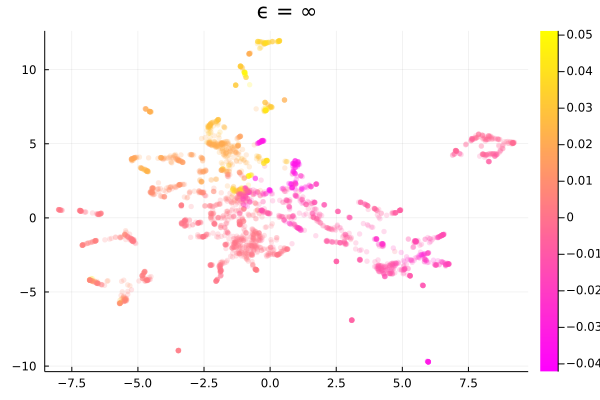

In [11]:
plt_umap_x = scatter(
    embedding_umap_x |> rdpg._Matrix_to_ArrayOfTuples,
    ma=0.2, ms=3, msw=0, legend=:bottomleft, label=nothing, c=:spring, #lim=(-12, 12),
    marker_z=z_vals,
    title="ϵ = ∞"
)

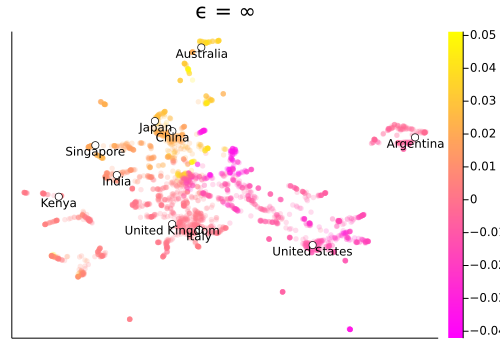

In [12]:
# noteworthy_airports = ["DCA", "SEA", "LGW", "FCO", "IST", "HFA", "DOH", "BLR", "SIN", "XIY", "NRT", "SYD", "BOB", "SCL" ,"AEP", "DUR", "NBO"]
noteworthy_airports = ["JFK", "FCO", "LGW", "SIN", "DEL", "XIY", "NRT", "SYD", "AEP", "NBO"]
airport_indices = findall(x -> x ∈ noteworthy_airports, labels[:, 2] )
plt_umap_x = Plots.scatter(
    plt_umap_x, size=(500,350),
    embedding_umap_x[airport_indices, :] |> rdpg._Matrix_to_ArrayOfTuples, label=nothing, c=:white, ticks=nothing,
    series_annotations = text.(labels[airport_indices, 6], valign=:top, halign=:center, pointsize=8, color=:black)
)

----

In [13]:
Random.seed!(2022)
ϵ = 2 * log(N) / (sqrt(N) * rho)
B = (rdpg.edgeFlip(A, ϵ=ϵ) .- rdpg.τ(ϵ)^2) ./ rdpg.σ(ϵ)^2
Ynh1, _ = rdpg.spectralEmbed(B, d=dim, scale=false);

In [14]:
embedding_umap_y1 = umap(Ynh1', 2; umap_params...)';

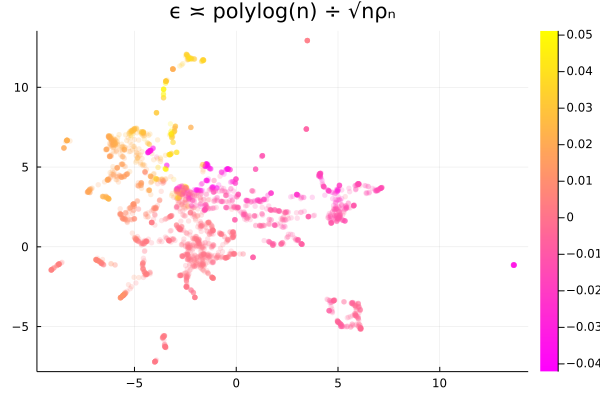

In [15]:
plt_umap_y1 = scatter(
    embedding_umap_y1 |> rdpg._Matrix_to_ArrayOfTuples,
    ma=0.2, ms=3, msw=0.0, legend=:bottomleft, label=nothing, c=:spring, #lim=(-12, 12),
    marker_z=z_vals,
    # group=labels[:, 2],
    title="ϵ ≍ polylog(n) ÷ √nρₙ"
)

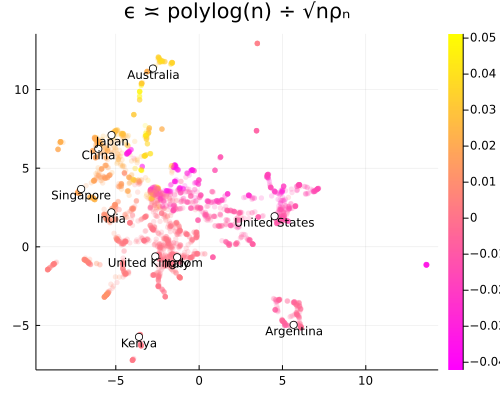

In [16]:
plt_umap_y1 = Plots.scatter(
    plt_umap_y1, size=(500, 400),
    embedding_umap_y1[airport_indices, :] |> rdpg._Matrix_to_ArrayOfTuples, label=nothing, c=:white,
    series_annotations = text.(labels[airport_indices, 6], valign=:top, halign=:center, "sans-serif", pointsize=8, color=:black)
)

----

In [25]:
Random.seed!(2022)
ϵ = 2 * log(N) / (N * rho)
B = (rdpg.edgeFlip(A, ϵ=ϵ) .- rdpg.τ(ϵ)^2) ./ rdpg.σ(ϵ)^2
Ynh2, _ = rdpg.spectralEmbed(B, d=dim, scale=false);

In [26]:
embedding_umap_y2 = umap(Ynh2', 2; umap_params...)';

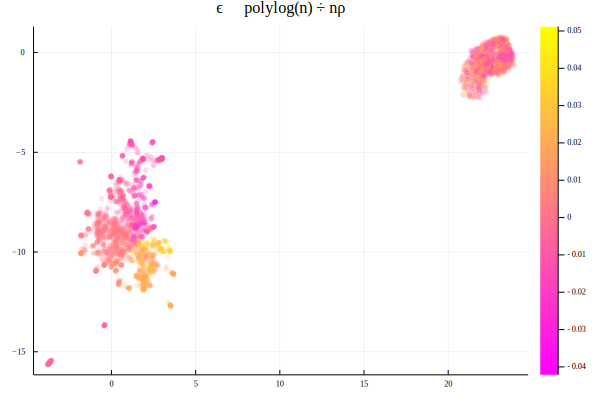

In [27]:
plt_umap_y2 = scatter(
    embedding_umap_y2 |> rdpg._Matrix_to_ArrayOfTuples,
    ma=0.2, ms=3, msw=0.00, legend=:bottomleft, label=nothing, c=:spring, #lim=(-12, 12),
    marker_z=z_vals,
    title="ϵ ≍ polylog(n) ÷ nρₙ"
)

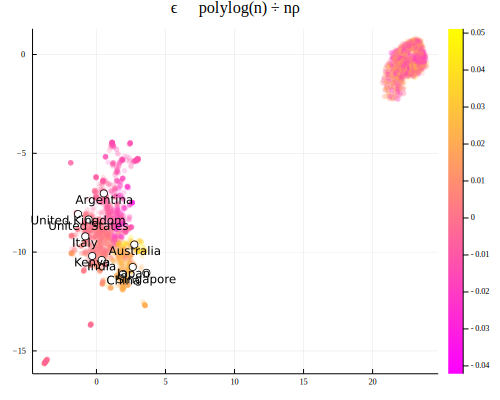

In [28]:
plt_umap_y2 = Plots.scatter(
    plt_umap_y2, size=(500, 400),
    embedding_umap_y2[airport_indices, :] |> rdpg._Matrix_to_ArrayOfTuples, label=nothing, c=:white,
    series_annotations = text.(labels[airport_indices, 6], valign=:top, halign=:center, "sans-serif", pointsize=8, color=:black)
)

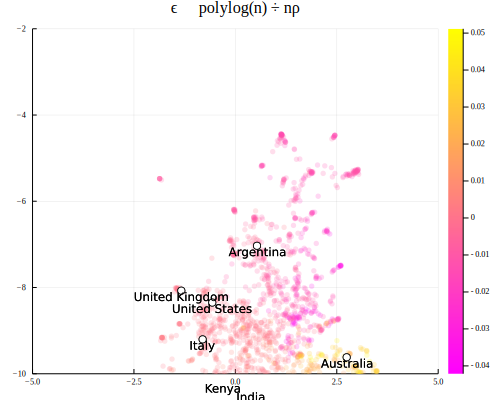

In [29]:
Plots.scatter(
    plt_umap_y2, size=(500, 400), xlim=(-5, 5), ylim=(-10, -2),
    embedding_umap_y2[airport_indices, :] |> rdpg._Matrix_to_ArrayOfTuples, label=nothing, c=:white,
    series_annotations = text.(labels[airport_indices, 6], valign=:top, halign=:center, "sans-serif", pointsize=8, color=:black)
)

In [22]:
# savefig(plt_umap_x, plotsdir("flights/plt_umap_x.pdf"))
# savefig(plt_umap_y1, plotsdir("flights/plt_umap_y1.pdf"))
# savefig(plt_umap_y2, plotsdir("flights/plt_umap_y2.pdf"))

In [68]:
using Plots, Plots.Measures
gr(titlefontsize=10, fontfamily="Times", legendfontsize=8, guidefontsize=8, tickfontsize=5, levels=5)
cls = palette(:linear_wcmr_100_45_c42_n256, 100, rev=false)
noaxis = (; axis=false, padding=false, ticks=false)
params = (; ratio=1, label="", size=(400, 400), outer=0, ma=0.5)
par = (; levels=10, lw=0, ratio=1, left_margin=2mm, bottom_margin=2mm)
labelpar = (; 
    label=nothing, c=:white, 
    series_annotations = text.(
        labels[airport_indices, 6], 
        valign=:top, halign=:center, 
        "Times", pointsize=8, color=:black
    )
);
plt_colorbar(t1=0.0, t2=1.0; kwargs...) = scatter(
    [0, 0], [0, 1],
    zcolor=[t1, t2], clims=(t1, t2),
    xlims=(1, 1.01),
    xshowaxis=false, yshowaxis=false, 
    label="", colorbar_title="",
    grid=false, levels=10,
    right_margin=-10mm,
    c=cls; kwargs...
)

plt_colorbar (generic function with 3 methods)

In [64]:
gr_cbar_width = Ref(0.0003)

Base.RefValue{Float64}(0.0003)

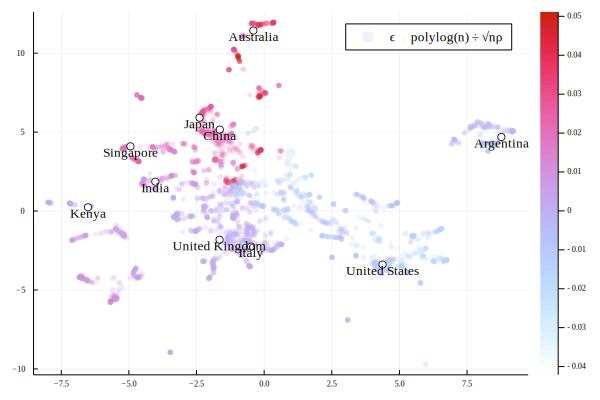

In [107]:
plt_umap_x = scatter(
    embedding_umap_x |> rdpg._Matrix_to_ArrayOfTuples,
    ma=0.2, ms=3, msw=0,
    c=cls, marker_z=z_vals,
    # label=nothing,
    label="ϵ ≍ polylog(n) ÷ √nρₙ",
    legend=:topright,
)
plt_umap_x = Plots.scatter(
    plt_umap_x, 
    # size=(500, 400), 
    embedding_umap_x[airport_indices, :] |> rdpg._Matrix_to_ArrayOfTuples;
    labelpar...)

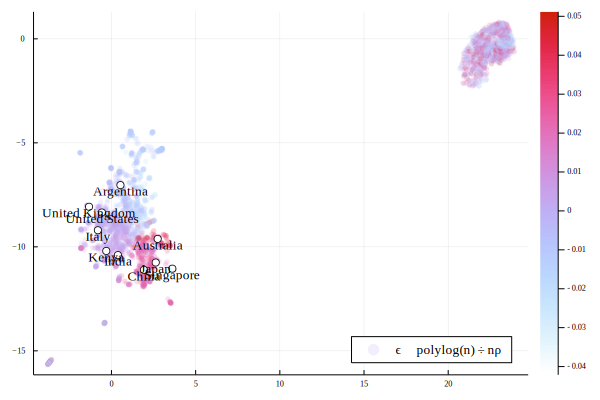

In [110]:
plt_umap_y2 = scatter(
    embedding_umap_y2 |> rdpg._Matrix_to_ArrayOfTuples,
    ma=0.2, ms=3, msw=0,
    c=cls, marker_z=z_vals,
    # label=nothing,
    label="ϵ ≍ polylog(n) ÷ nρₙ", 
    legend=:bottomright,
)
plt_umap_y2 = Plots.scatter(
    plt_umap_y2, 
    # size=(500, 400), 
    embedding_umap_y2[airport_indices, :] |> rdpg._Matrix_to_ArrayOfTuples;
    labelpar...)

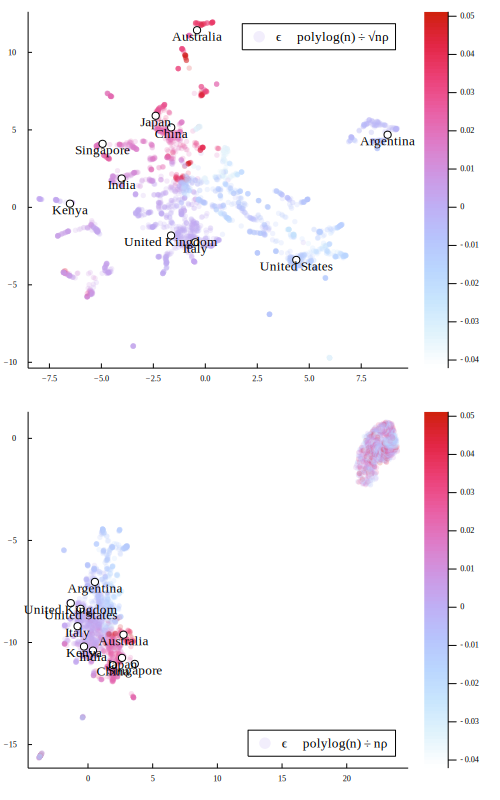

In [131]:
using LaTeXStrings
plot(
    plot(plt_umap_x, colorbar=false),
    plot(plt_umap_y2, colorbar=false),
    layout = Plots.grid(2,1), colorbar = true,
    # plt_colorbar(-0.04, 0.04, thickness_scaling=10; noaxis...),
    # layout=(@layout [Plots.grid(2,1) a{0.1w}]), 
    size=(500, 800), grid=false, fmt=:svg, legendfontfamily="Times"
    title = ["ϵ ≍ polylog(n) ÷ √nρ" "ϵ ≍ polylog(n) ÷ √nρ"]
)

In [128]:
savefig("~/work/julia/dp-rdpg/notebooks/fl.svg")